# First steps with TensorFlow:

## Constant tensors and variables:

In [1]:
import tensorflow as tf
## Tensor of all ones
x = tf.ones(shape=(2, 1))
print(x)

2023-12-15 22:14:49.185283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
## Tensor of zeros
x = tf.zeros(shape=(4,1))
print(x)

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]], shape=(4, 1), dtype=float32)


In [3]:
## Tensor of random values drawn from a normal distribution with mean 0 and standard deviation 1
x = tf.random.normal(shape=(3,1),mean=0,stddev=1.0)
print(x)
## Tensor of random values drawn from a uniform distribution between 0 and 1
x = tf.random.uniform(shape=(3,1),minval=0.0,maxval=1.0)
print(x)

tf.Tensor(
[[0.26426426]
 [0.32878762]
 [0.06040859]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.08833361]
 [0.26873803]
 [0.85761166]], shape=(3, 1), dtype=float32)


### TensorFlow tensors are not assignable:

In [4]:
import numpy as np
x = np.ones(shape=(2,1))
print(x)

[[1.]
 [1.]]


In [5]:
x[0,0] = 0
print(x)


[[0.]
 [1.]]


In [7]:
x = tf.ones(shape=(2,1))

In [8]:
x[0,0]=0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

#### To train a model, we’ll need to update its state, which is a set of tensors. If tensors aren’t assignable, how do we do it? That’s where variables come in. tf.Variable is the class meant to manage modifiable state in TensorFlow

In [9]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-1.2727126 ],
       [ 0.21398926],
       [-1.0945963 ]], dtype=float32)>


In [10]:
v.assign(tf.ones(shape=(3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [11]:
v[0,0].assign(3)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [12]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

In [13]:
v.assign_sub(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

## Tensor operations: Doing math in TensorFlow:

In [20]:
a = tf.random.normal(shape=(2, 2),mean=5.0,stddev=1.0)

In [21]:
b = tf.square(a) ## Take the square.
c = tf.sqrt(a) ## Take the square root.
d = b+c ## Add two tensors (element-wise)
e = tf.matmul(a,b) ##Take the product of two tensors
e*=d ## Multiply two tensors (element-wise).

In [22]:
print(e)

tf.Tensor(
[[9186.456  2236.7754]
 [7901.6167 2255.8328]], shape=(2, 2), dtype=float32)


In [23]:
print(b)

tf.Tensor(
[[30.957481  14.3917885]
 [27.279526  14.977255 ]], shape=(2, 2), dtype=float32)


In [24]:
print(d)

tf.Tensor(
[[33.316284 16.339518]
 [29.56491  16.944498]], shape=(2, 2), dtype=float32)


In [25]:
print(c)

tf.Tensor(
[[2.3588016 1.9477297]
 [2.2853842 1.9672432]], shape=(2, 2), dtype=float32)


In [26]:
print(a)

tf.Tensor(
[[5.563945  3.793651 ]
 [5.2229805 3.870046 ]], shape=(2, 2), dtype=float32)


## A second look at the GradientTape API:

In [27]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

In [28]:
input_const = tf.constant(3.) 
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)


In [35]:
time = tf.Variable(2.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape: 
        position = 4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

In [36]:
acceleration

<tf.Tensor: shape=(), dtype=float32, numpy=9.8>

In [37]:
speed

<tf.Tensor: shape=(), dtype=float32, numpy=19.6>

## An end-to-end example: A linear classifier in pure TensorFlow

#### Generating two classes of random points in a 2D plane:

In [38]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class) # Generate the first class of points: 1000 random 2D points. 
                                #cov=[[1, 0.5],[0.5, 1]] corresponds to an oval-like point cloud oriented from bottom left to top right.
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class) #Generate the other class of points with a different mean and the same covariance matrix.

#### Stacking the two classes into an array with shape (2000, 2):

In [39]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)


#### Generating the corresponding targets (0 and 1):

In [40]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"), np.ones((num_samples_per_class, 1), dtype="float32")))


#### Plotting the two point classes:

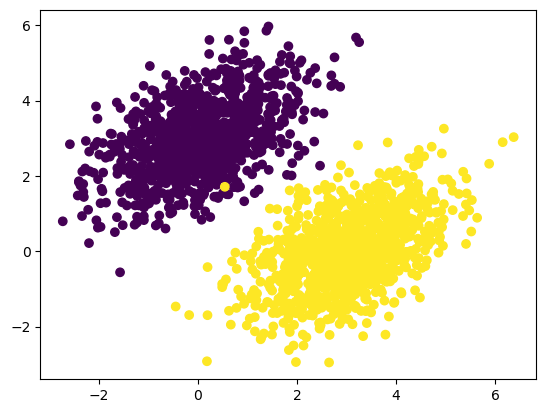

In [41]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0]) 
plt.show()

#### Creating the linear classifier variables

In [42]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim))) 
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

#### The forward pass function

In [43]:
def model(inputs):
    return tf.matmul(inputs, W) + b

#### The mean squared error loss function

In [45]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions) 
    return tf.reduce_mean(per_sample_losses)


#### The training step function

In [46]:
learning_rate = 0.1
def training_step(inputs, targets):
    with tf.GradientTape() as tape: 
        predictions = model(inputs) ## Forward pass, inside a gradient tape scope
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b]) # Retrieve the gradient of the loss with regard to weights.
    W.assign_sub(grad_loss_wrt_W * learning_rate) 
    b.assign_sub(grad_loss_wrt_b * learning_rate) 
    return loss
        

#### The batch training loop

In [48]:
for step in range(40):
    loss = training_step(inputs, targets) 
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.8411
Loss at step 1: 0.3434
Loss at step 2: 0.1442
Loss at step 3: 0.1119
Loss at step 4: 0.1016
Loss at step 5: 0.0946
Loss at step 6: 0.0886
Loss at step 7: 0.0831
Loss at step 8: 0.0781
Loss at step 9: 0.0735
Loss at step 10: 0.0693
Loss at step 11: 0.0655
Loss at step 12: 0.0620
Loss at step 13: 0.0588
Loss at step 14: 0.0559
Loss at step 15: 0.0532
Loss at step 16: 0.0508
Loss at step 17: 0.0486
Loss at step 18: 0.0465
Loss at step 19: 0.0447
Loss at step 20: 0.0430
Loss at step 21: 0.0414
Loss at step 22: 0.0400
Loss at step 23: 0.0387
Loss at step 24: 0.0375
Loss at step 25: 0.0364
Loss at step 26: 0.0354
Loss at step 27: 0.0345
Loss at step 28: 0.0337
Loss at step 29: 0.0329
Loss at step 30: 0.0322
Loss at step 31: 0.0316
Loss at step 32: 0.0310
Loss at step 33: 0.0305
Loss at step 34: 0.0300
Loss at step 35: 0.0296
Loss at step 36: 0.0292
Loss at step 37: 0.0288
Loss at step 38: 0.0285
Loss at step 39: 0.0282


#### Predictions from the model

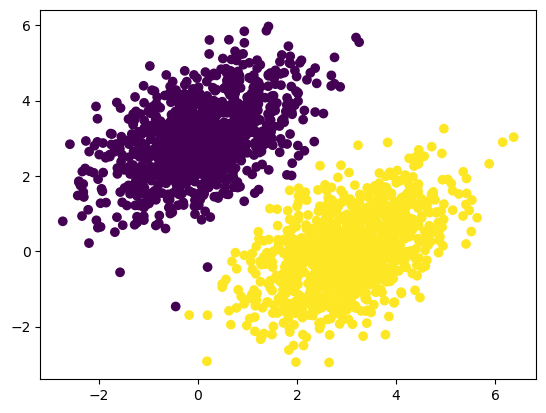

In [49]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

#### Predictions with the line separating the classes

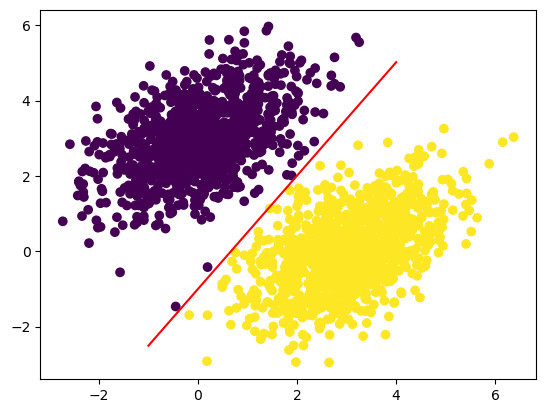

In [50]:
x = np.linspace(-1, 4, 100)
y=-W[0]/ W[1]*x+(0.5-b)/W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Layers: The building blocks of deep learning:

### THE BASE LAYER CLASS IN KERAS

In [53]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):
    def __init__(self,units,activation=None):
        super().__init__()
        self.units = units
        self.activation = activation
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim,self.units),initializer="random_normal") #add_weight() is a shortcut method for creating weights. 
        #It is also possible to create standalone variables and assign them as layer attributes, 
        #like self.W = tf.Variable(tf.random.uniform(w_shape)).
        self.b = self.add_weight(shape=(self.units,),initializer="zeros")
    def call(self,inputs):
        y = tf.matmul(inputs,self.W)+self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [54]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [55]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [56]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [57]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

#### The "compile" step: Configuring the learning process

In [58]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])


In [59]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

#### Understanding the fit() method

##### Calling fit() with NumPy data

In [60]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 1s 6ms/step - loss: 1.2171 - binary_accuracy: 0.0895
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 1.0984 - binary_accuracy: 0.1095
Epoch 3/5
16/16 [==============================] - 0s 5ms/step - loss: 1.0018 - binary_accuracy: 0.1300
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 0.9126 - binary_accuracy: 0.1485
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.8288 - binary_accuracy: 0.1720


In [61]:
history.history

{'loss': [1.2170758247375488,
  1.0984079837799072,
  1.001786231994629,
  0.9125608801841736,
  0.8287734985351562],
 'binary_accuracy': [0.08950000256299973,
  0.10949999839067459,
  0.12999999523162842,
  0.148499995470047,
  0.1720000058412552]}

### Monitoring loss and metrics on validation data

#### Using the validation_data argument

In [62]:
model = keras.Sequential([keras.layers.Dense(1)]) 
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation] 
shuffled_targets = targets[indices_permutation]
num_validation_samples = int(0.3 * len(inputs))

val_inputs = shuffled_inputs[:num_validation_samples] 
val_targets = shuffled_targets[:num_validation_samples] 
training_inputs = shuffled_inputs[num_validation_samples:] 
training_targets = shuffled_targets[num_validation_samples:]

model.fit(training_inputs,
          training_targets,
          epochs=5,
          batch_size=16,
          validation_data=(val_inputs,val_targets))

Epoch 1/5
88/88 [==============================] - 1s 6ms/step - loss: 0.2530 - binary_accuracy: 0.9529 - val_loss: 0.3135 - val_binary_accuracy: 0.7967
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0780 - binary_accuracy: 0.9521 - val_loss: 0.0234 - val_binary_accuracy: 1.0000
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0706 - binary_accuracy: 0.9607 - val_loss: 0.0337 - val_binary_accuracy: 1.0000
Epoch 4/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0706 - binary_accuracy: 0.9629 - val_loss: 0.0968 - val_binary_accuracy: 0.9433
Epoch 5/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0803 - binary_accuracy: 0.9507 - val_loss: 0.0278 - val_binary_accuracy: 1.0000


In [63]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 [==============================] - 0s 3ms/step - loss: 0.0278 - binary_accuracy: 1.0000


### Inference: Using a model after training 

In [64]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 2ms/step
[[0.36425042]
 [0.91391647]
 [1.214598  ]
 [0.09732631]
 [0.86650103]
 [0.9666648 ]
 [0.13973603]
 [1.0931016 ]
 [1.2533312 ]
 [0.15330029]]
